In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag
import bs4
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from lxml import html
import lxml
import collections.abc as clct

In [25]:
%load_ext autoreload
%autoreload 2

## Searching for croissant baking temperatures
- Searches for 'croissant bake temperature' or 'temperature cuisson croissant' were conducted on Google country-specific search sites for the US, UK, and France. The first 100 links were obtained for each country. These links were subsequently scraped to determine if they were a croissant baking recipe, and if so, for their initial baking temperature.
- Baking temperatures were found by looking for sentences that contained the words 'preheat', 'bake', or 'oven' followed by a 3 digit number followed by a temperature indicator. 
- Croissant baking often employs a two-stage approach with a high starting temp followed by a lower finishing temp. The script pulled the first temperature mention, so this is the starting temp.
- For the US graphic, websites were excluded if the first temperature mention was in celsius.
- For the UK and French graphics, websites were excluded if the first temperature mention was in fahrenheit.


## Tools and techniques used in this project
- **Tools**
> - Python, Jupyter Lab, Beautiful Soup, Pandas, Numpy
- **Visualization**
> - Matplotlib
- **Techniques**
> - Web-scraping


In [2]:
def get_links_from_google_search(google_url):
    '''
    Given a Google search string, returns links from that Google search page
    Parameters:
    ----------
    google_url (str): a google search string. To get past the first page, replace start=0 with start={bundle}.
    Returns:
    -------
    links (list): a list of links 
    '''
    links_ = []
    driver = webdriver.Firefox()
    time.sleep(30) # slow requests down to keep google from getting upset
    driver.get(google_url)
    soup = BeautifulSoup(driver.page_source,'lxml')
    result_div = soup.find_all('div', attrs={'class': 'g'})
    for r in result_div:
            try:
                link = r.find('a', href=True)
                if link != '':
                    # site exceptions
                    if 'google.' not in link and 'costco.' not in link and 'freshdirect' not in link: 
                        links_.append(link['href'])
                
            except Exception as e:
                print(e)
                continue
    return(links_)


In [3]:
def find_value_of_nested_dict_or_list(a, our_key):
    if not isinstance(a, clct.Iterable):
        return False
    if isinstance(a, str):
        return False
    if isinstance(a, list):
        for item in a:
            result = find_value_of_nested_dict_or_list(item, our_key)
            if result:
                return result
    if isinstance(a, dict):
        for key in a:
            if key == our_key:
                return a[our_key]
            else:
                result = find_value_of_nested_dict_or_list(a[key], our_key)
                if result:
                    return result
    return False

In [4]:
# not in use
def string_from_soup(content):
#     print(content)
    if isinstance(content, str):
        return content
    elif isinstance(content, bs4.element.Tag):
        return content.text
    elif isinstance(content, list):
        for item in content:
            result = string_from_soup(item)
            if result:
                return result
    else:
        return 'Not list or string'

In [34]:
url = 'https://www.marthastewart.com/312981/croissants' # 3 1st level is list. target dict is in 2nd position of list
url = 'https://sallysbakingaddiction.com/homemade-croissants/' # 1. type(data) dict. 
# url = 'https://www.kingarthurbaking.com/recipes/bakers-croissants-recipe' # 1target in dict?
# url = 'https://www.finecooking.com/recipe/classic-croissants' # target in dict
# url = 'https://www.jocooks.com/recipes/homemade-croissants/' # target in dict

# url = 'https://www.epicurious.com/recipes/food/views/butter-croissants-103989' #No application/ld+json. Yes to schema.org recipe, but old format
# url = 'https://www.weekendbakery.com/posts/classic-french-croissant-recipe/' # No application/ld+json
# url = 'https://gourmetier.com/french-croissants/'   # class="entry-content". dict, but target not in dict
# url = 'https://topwithcinnamon.com/how-to-make-croissants/'  # dict, but target not in dict
# url = 'https://www.noellecarterfood.com/blog/2019/9/20/better-baking-temperature-croissants-recipe' # dict, but target not in dict

# url = 'https://bakingamoment.com/easy-homemade-croissant-recipe/'
# url = 'https://www.joyofbaking.com/breads/HomemadeCroissants.html'
# url = 'https://www.foodandwine.com/recipes/croissants'
# url = 'https://bakerpedia.com/processes/croissant/'
# url = 'https://www.halfbakedharvest.com/homemade-croissants-step-step-photos/'
# url = 'https://www.foodnetwork.com/recipes/food-network-kitchen/homemade-croissants-5277802'
# url = 'https://www.tastingtable.com/cook/recipes/croissants-recipe-french-pastry'
# url = 'https://www.bbcgoodfood.com/recipes/croissants' #recipeInstructions appears twice. Value is erased on the second pass?
# url = 'https://www.masterclass.com/articles/make-the-perfect-croissant-with-chef-dominique-ansel' # not working--probable redirect
# url = 'https://buttermilkpantry.wordpress.com/2019/07/06/how-to-make-croissants/' # not working--"Connection aborted"

# url = 'https://www.artisanbryan.com/post/how-to-make-croissants-recipe'
# url = 'https://www.paulhollywood.com/post/croissants'
url = 'https://www.thekitchn.com/how-to-make-puff-pastry-222312'
try:       
    r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
    if r.status_code == 406:
        r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html')
        json_data = soup.findAll(type="application/ld+json")

#         print(soup.prettify())
        print(len(json_data))
        if len(json_data) > 0:                # For sites that follow schema.org for 'Recipe'
                    for i in range(len(json_data)):
                        data = json.loads(json_data[i].string)
#                         self.ingredients = find_value_of_nested_dict_or_list(data,'recipeIngredient')
#                         print(url)
                        check = find_value_of_nested_dict_or_list(data,'recipeInstructions')
                        if check:
                            instr = []
                            if isinstance(check[0], dict):
                                for dct_ in check:
                                    if 'text' in dct_.keys():
                                        instr = dct_['text']
                                        print(instr)
                            else:
                                instr = ''.join(check)
#                                 print(instr)
#                         self.recipe_name = find_value_of_nested_dict_or_list(data,'name')
#                         self.cook_time = find_value_of_nested_dict_or_list(data,'cookTime')
#                         self.url = url

#         if len(json_data) == 0 or find_value_of_nested_dict_or_list(data,'recipeInstructions') == False:     # For sites that do not follow schema.org for 'Recipe'
#                     result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 
#                                                                    'hrecipe', 'post-entry', 'post-content', 'post-content__body','recept', 'recipe-content']})
#                     soup_string = ''
#                     for r in result:
#                         soup_string += str(r.text)
#                     print(url)
#                     print(len(soup_string))
#                     self.instructions = soup_string
#                     self.url = url


                        
#         result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 'post-entry', 'recept', 'recipe-content']})
#         soup_string = ''
#         for r in result:
#             soup_string += str(r.text)
        
#         print(soup_string)

except Exception as e:
    print('Exception', e)
# instr

3
Make the lean dough: Mix the flour with the salt, then turn out onto your work surface in a pile. Run your fingers down the center to create a trough. Sprinkle 1 tablespoon of water into the trough. Quickly fluff the dough with your fingers, keeping your fingers loose and using a scooping motion. Gather the flour back in to a mound, create a trough, and add another tablespoon of water. Continue sprinkling and fluffing until the flour clumps together in large pieces and holds together when pressed.
Chill the dough: Press the dough into a square and wrap in plastic. It&#x27;s fine if it looks a little shaggy and unkempt at this stage. Refrigerate for at least 30 minutes.
Prepare the butter block: Cut the butter into a few large pieces and sprinkle with a teaspoon of flour. Begin pounding the butter with a French rolling pin to soften it, sprinkling flour on your rolling pin as needed. Pound the butter flat, then use a pastry scraper to gather it up again. Sprinkle with another teaspoon

In [5]:
class ClassifyWebpage:
    '''Classify webpage'''
    def __init__(self, search_pattern_1, search_pattern_2):
        self.url = None
        self.page_genus = 'pastry'
        self.page_family = ''
        self.page_species = ''
#         self.pastry_genus_predict = PastryRecipeWebpage()
#         self.pastry_family_predict = PastryRecipeWebpage()
#         self.pastry_species_predict = PastryRecipeWebpage()
        self.language = "Not found in page source"
        self.recipe_name = ''
        self.cook_time = ''
        self.ingredients = ''
        self.instructions = ''
    
    def parse_webpage(self, url):
        try:
            r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
            if r.status_code == 406:
                r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
            if r.status_code == 200:
#                 print(f'Pass {url}')
                root = lxml.html.fromstring(r.text)
                language_construct = root.xpath("//html/@lang") # this xpath is reliable(in long-term), since this is a standard construct.
                if language_construct:
                    language = language_construct[0].split('-')[0]
                    self.language = language    
        
                soup = BeautifulSoup(r.content, 'html')
                json_data = soup.findAll(type="application/ld+json")

                # For sites that follow schema.org for 'Recipe'
                if len(json_data) > 0:                
                    for i in range(len(json_data)):
                        data = json.loads(json_data[i].string)
                        check = find_value_of_nested_dict_or_list(data,'recipeInstructions')
                        if check:
                            instr = []
                            if isinstance(check[0], dict):
                                for dct_ in check:
                                    if 'text' in dct_.keys():
                                        self.instructions = dct_['text']
#                                         print(instr)
                            else:
                                instr = ''.join(check)
                                self.instructions = instr
                            self.ingredients = find_value_of_nested_dict_or_list(data,'recipeIngredient')
                            self.recipe_name = find_value_of_nested_dict_or_list(data,'name')
                            self.cook_time = find_value_of_nested_dict_or_list(data,'cookTime')
                            self.url = url

                # For sites that do not follow schema.org for 'Recipe'
                if len(json_data) == 0 or find_value_of_nested_dict_or_list(data,'recipeInstructions') == False:     
                    result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 
                                                                   'hrecipe', 'post-entry', 'post-content', 
                                                                   'post-content__body','recept', 'recipe-content']})
                    soup_string = ''
                    for r in result:
                        soup_string += str(r.text)
                    self.instructions = soup_string
                    self.url = url
                
                return {'instructions' : self.instructions,
                        'url' : self.url
                       }
                              
            else:
                print(' ')
#                 print(f'Fail {r.status_code}, {url}')
        except Exception as e:
            pass
            print('Exception', e)
            


In [6]:
class PastryRecipeWebpage:
    '''A recipe for hand-made croissants'''
    def __init__(self, instructions=None, initial_temp=None, second_temp=None):
        '''Initialize the recipe's attributes'''
        self.instructions = instructions
        self.initial_temp = initial_temp
        if initial_temp and initial_temp > 300:
            self.initial_temp_range = 'US'
        else:
            self.initial_temp_range = 'Europe'
        self.second_temp = second_temp
    

## Step one
### Get links for the target search term

In [15]:
#  The easiest way to change the search is to type a search in google then COPY and PASTE the address. If you try to assign variable to the function call it won't recognize {bundle}.
#  Convert to an f string, find start=0 in the string and change it to start={bundle}.

# us_puff_pastry = f'https://www.google.com/search?q=how+to+make+puff+pastry+dough&client=ubuntu&hs=GNM&channel=fs&sxsrf=ALeKk011tOIIja512_JwZ8zfTmHSiLc9HA:1598459179879&ei=K41GX96hNcP7-gTrwZCYAg&start={bundle}&sa=N&ved=2ahUKEwie4-q8pLnrAhXDvZ4KHesgBCMQ8NMDegQIDhBA&biw=1637&bih=942'
# us_ciambellone = f'https://www.google.com/search?q=how+to+make+ciambellone&client=ubuntu&hs=GlP&channel=fs&sxsrf=ALeKk03eb_8FF-pe9XNVMG56gUih10WpYA:1598472199741&ei=B8BGX83oLIvJ0PEPr-2ryAQ&start={bundle}&sa=N&ved=2ahUKEwiNiJj91LnrAhWLJDQIHa_2CkkQ8NMDegQIDBBA&biw=1637&bih=942'
# us_google_url=f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969"
# fr_google_url=f"https://www.google.fr/search?q=temp%C3%A9rature+cuisson+croissant&ei=0PEzX4C2PMXk-gTv_ImwCA&start={bundle}&sa=N&ved=2ahUKEwiA3szk5ZXrAhVFsp4KHW9-AoYQ8NMDegQIDRBC&biw=1848&bih=942"
# uk_google_url=f"https://www.google.co.uk/search?q=croissant+temperature&ei=OPQzX8T0KMj4-gSnn5moBw&start={bundle}&sa=N&ved=2ahUKEwjE8JaK6JXrAhVIvJ4KHadPBnUQ8NMDegQIDhA_&biw=1848&bih=942"

target_links = 120
page_bundles = list(range(0,target_links,10))
cake_links=[]
for bundle in page_bundles:
    links_list = get_links_from_google_search(f'https://www.google.com/search?q=how+to+make+ciambellone&client=ubuntu&hs=GlP&channel=fs&sxsrf=ALeKk03eb_8FF-pe9XNVMG56gUih10WpYA:1598472199741&ei=B8BGX83oLIvJ0PEPr-2ryAQ&start={bundle}&sa=N&ved=2ahUKEwiNiJj91LnrAhWLJDQIHa_2CkkQ8NMDegQIDBBA&biw=1637&bih=942')
    for link in links_list:
        cake_links.append(link)

In [16]:
len(cake_links)

117

### Write results to file from Google search function

In [17]:
# Uncomment country to write results

# uk_croissant_links = pd.DataFrame(links)
# uk_croissant_links.to_csv('data/uk-croissant-links.txt')

# us_croissant_links = pd.DataFrame(links)
# us_croissant_links.to_csv('data/us-croissant-links.txt')

# us_puff_pastry_links = pd.DataFrame(puff_links)
# us_puff_pastry_links.to_csv('data/us-puff-pastry-links.txt')

# us_cake_pastry_links = pd.DataFrame(cake_links)
# us_cake_pastry_links.to_csv('data/us-ciambellone-links.txt')

# fr_croissant_links = pd.DataFrame(links)
# fr_croissant_links.to_csv('data/fr-croissant-links.txt')

## Step two
### Read in links file and initiate web search

In [59]:
# url_list = pd.read_csv('data/fr-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/uk-croissant-links.txt',header=None)
url_puff = pd.read_csv('data/us-puff-pastry-links.txt',header=None)
url_csnt = pd.read_csv('data/us-croissant-links.txt', header=None)
url_cake = pd.read_csv('data/us-ciambellone-links.txt', header=None)

In [60]:
from scraper import *
search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

scraper = ScrapePage('cake', 'ciambellone', search_string_1, search_string_2)

# csnt_recipes = []
# for i in range(40):
#     csnt_recipes.append(scraper.scrape_page(url_csnt[1][i]))

# cake_recipes = []
# for i in range(40):
#     cake_recipes.append(scraper.scrape_page(url_cake[1][i]))

puff_recipes = []
for i in range(9):
    puff_recipes.append(scraper.scrape_page(url_cake[1][i]))
# test = scraper.scrape_page(url_puff[1][5])
# test

Exception Invalid URL '0': No schema supplied. Perhaps you meant http://0?
Success 200, https://www.mangiabedda.com/orange-ciambella/
Success 200, https://www.shelovesbiscotti.com/traditional-italian-citrus-ring-cake/
Success 200, https://honestcooking.com/ciambellone-ring-cake-old-days-italian-staple/
Success 200, https://www.localaromas.com/classic-homemade-italian-ciambellone-cake-recipe/
Success 200, https://www.savoringitaly.com/ciambella-romagnola-italian-breakfast/
Success 200, https://www.epicurious.com/recipes/food/views/nonna-marys-ciambella-395729
Exception ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Success 200, https://giadzy.com/recipes/giadas-ciambella-cake/


In [61]:
for recipe in puff_recipes:
    print(recipe.url)
    print(recipe.instructions)

0

https://www.mangiabedda.com/orange-ciambella/
Preheat oven to 350F and grease a tube pan with butter or cooking spray.In a large bowl, whisk eggs, sugar and vegetable oil until pale and frothy.Stir in orange zest and juice.Sift flour, baking powder and salt. Stir into the wet ingredients with a wooden spoon or spatula until just combined.Pour batter into the prepared tube pan. Bake for 35 minutes until a toothpick inserted in the center comes out clean.Transfer to a cooling rack. After 10 minutes, run a knife around the edges of the pan to loosen the cake. Unmold and let cool completely on the wire rack.Lightly dust with powdered sugar before serving.
https://www.shelovesbiscotti.com/traditional-italian-citrus-ring-cake/
Preheat the oven to 350℉ (175°C) .Grease and flour (or use non-stick spray) a 10-inch bundt pan.In a medium bowl,sift together flour, baking powder and salt. Set aside.In a large mixing bowl (of stand mixer) beat the eggs on high speed for about 3 minutes (eggs will

In [19]:
print(url_list)

         0                                                  1
0      NaN                                                  0
1      0.0  https://m.youtube.com/watch?v=g-dF_j3AVTw&feat...
2      1.0  https://m.youtube.com/watch?v=g-dF_j3AVTw&feat...
3      2.0          https://en.wikipedia.org/wiki/Puff_pastry
4      3.0  https://www.thekitchn.com/make-or-buy-puff-pas...
..     ...                                                ...
198  197.0  http://gratil.sevilenhurdacilik.xyz/almond-tar...
199  198.0  https://thedomesticrebel.com/2020/08/25/chocol...
200  199.0  http://ba.8muse.it/pastries-from-around-the-wo...
201  200.0  https://www.houstonchronicle.com/life/food/art...
202  201.0  https://breakfastideasaaliyah.web.app/2079-rec...

[203 rows x 2 columns]


In [20]:
# search_string_1 = r'([A-Z][^.]*(?:four|cuisson|cuir|chauff)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #French regex
# search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:ºC| ºC|°C| °C|C| C)[^.]*(?:[.]|[\s]))' #UK regex
search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

good_url, bad_url, instr, init_temp, init_temp_range = [], [], [], [], []
hits = 0
misses = 0

recipe_dict = []

scraper = ClassifyWebpage(search_string_1, search_string_2)

for i in range(40):
    recipe_dict.append(scraper.parse_webpage(url_list[1][i]))
    time.sleep(1)
print(len(recipe_dict))

Exception Invalid URL '0': No schema supplied. Perhaps you meant http://0?
 
 
Exception the JSON object must be str, bytes or bytearray, not NoneType
40


In [21]:
recipe_dict

[None,
 None,
 None,
 {'instructions': '', 'url': 'https://en.wikipedia.org/wiki/Puff_pastry'},
 {'instructions': '',
  'url': 'https://www.thekitchn.com/make-or-buy-puff-pastry-157266'},
 {'instructions': 'Cool completely: Baked puff pastry is at its crispiest best the same day it&#x27;s made, but will keep quite well in airtight containers for a few days.',
  'url': 'https://www.thekitchn.com/how-to-make-puff-pastry-222312'},
 {'instructions': 'Repeat about 2 to 4 times, wrap the dough in plastic wrap, and chill for 2 hours or overnight.*',
  'url': 'https://bakingamoment.com/easy-homemade-puff-pastry-recipe/'},
 {'instructions': "Roll out with flour for desired puff pastry use. Please note that this recipe does not have baking temperature and time, because you're supposed to use this pastry in any recipe that calls for one sheet of puff pastry. Understand?",
  'url': 'https://www.dessertfortwo.com/15-minute-puff-pastry/'},
 {'instructions': "Roll out with flour for desired puff past

In [22]:
for recipe in recipe_dict:
    print(len(recipe['instructions']))

TypeError: 'NoneType' object is not subscriptable

In [28]:
for page in recipe_dict:
    if page != None:
        if page.instructions:
            if len(page.instructions)>0:
                good_url.append(page.url)
                instr.append(page.instructions)
                hits += 1
                       
            else:
                print(page.url)
                print("NO DATA")
                bad_url.append(page.url)
                misses += 1
print(f': Hits {hits}  Misses {misses}')

df = pd.DataFrame([good_url, instr]).T
# df = pd.DataFrame([good_url, instr, init_temp]).T

AttributeError: 'dict' object has no attribute 'instructions'

In [222]:
print(len(recipe_dict))

54


### Write search results to file

In [212]:
# Uncomment country to write results

us_df_croissant2 = pd.DataFrame(df)
us_df_croissant2.to_csv('data/us_croissant2.csv')

# uk_df = pd.DataFrame(df)
# uk_df.to_csv('data/uk_results.csv')

# fr_df = pd.DataFrame(df)
# fr_df.to_csv('data/fr_results.csv')

In [221]:
us_df_croissant2

,0,1
0,https://sallysbakingaddiction.com/homemade-cro...,Croissants taste best the same day they’re bak...
1,https://www.kingarthurbaking.com/recipes/baker...,For the dough: Put the eggs and water in a lar...
2,https://www.epicurious.com/recipes/food/views/...,YieldMakes 24 pastries\nActive Time2 hr\nTotal...
3,https://www.weekendbakery.com/posts/classic-fr...,It’s all about the layers…\nKlik hier voor Ned...
4,https://www.finecooking.com/recipe/classic-cro...,Combine all of the dough ingredients in the bo...
5,https://www.jocooks.com/recipes/homemade-crois...,Bake croissants: Preheat your oven to 400 F de...
6,https://topwithcinnamon.com/how-to-make-croiss...,\n\nCroissants are just one of those things wh...
7,https://gourmetier.com/french-croissants/,The preparation of the croissants consists of ...
8,https://www.marthastewart.com/312981/croissants,"Brush with egg: Preheat oven to 400 degrees, w..."
9,https://www.noellecarterfood.com/blog/2019/9/2...,“Chilled.” “Room temperature.” “Melted.” These...


## Results and visualizations
- Of the 100 links obtained from the Google search by country, 35-40 usable temperatures were obtained for the US distribution and for the French distribution.
- Only 10 usable temperatures were obtained for the UK distribution. This is likely due to many recipes of US origin appearing in the google.uk search and being filtered out due to the restriction that temps needed to be expressed primarily in celsius.
- Mean temperatures are similar for all three countries.
- The distributions are different for the countries with the US having a narrower distribution of initial baking temperature and the French distribution being wider.

In [132]:
data_us = pd.read_csv('data/us_results.csv',header=None)
data_uk = pd.read_csv('data/uk_results.csv',header=None)
data_fr = pd.read_csv('data/fr_results.csv',header=None)

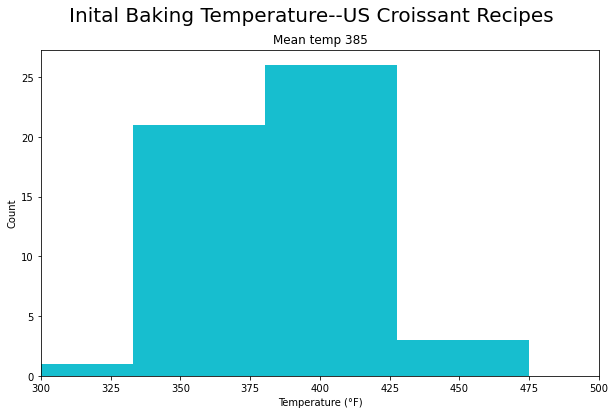

In [139]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(data_us.iloc[:,3], color='tab:cyan')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--US Croissant Recipes', size =20)
ax.set_title(f'Mean temp {data_us.iloc[:,3].mean():.0f}')
plt.savefig('img/us-croissant-baketemp-distribution.png')


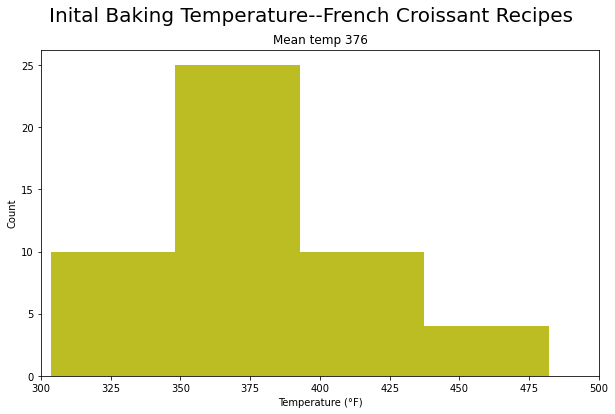

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_fr.iloc[:,3]*9/5+32), color='tab:olive')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--French Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_fr.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/fr-croissant-baketemp-distribution.png')
# (data_uk.iloc[:,2]*9/5+32).hist()
# (data_fr.iloc[:,2]*9/5+32).hist()


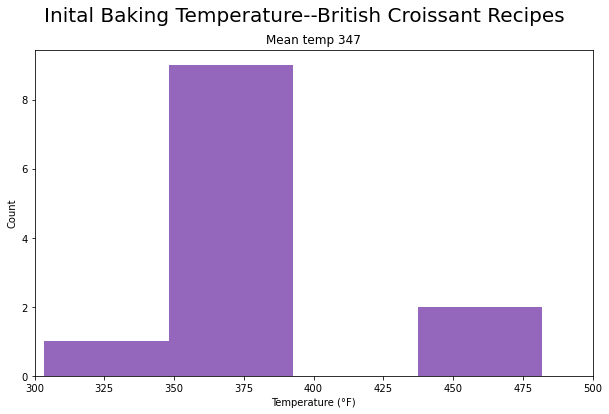

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_uk.iloc[:,3]*9/5+32), color='tab:purple')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--British Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_uk.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/uk-croissant-baketemp-distribution.png')


## Future Research
- Seek to obtain more usable temperatures by grabbing more links from Google and/or by refining the sifting of the websites to obtain a better yield.
- Consider how best to compare the distributions.
- Explore other parameters of croissant preparation and baking.
- Explore the comments for the various websites to determine if people in the respective countries interact differently with recipe authors.